In [1]:
import pandas as pd
import numpy as np
import math, re, os, cv2
import random
import gc
from tqdm import tqdm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
# from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from skimage.util import random_noise
from skimage.transform import rotate, AffineTransform, warp

Tensorflow version 2.10.1


c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

In [2]:
# test for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import tensorflow as tf

def set_gpu_device():

    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Call the function to set GPU device

set_gpu_device()
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("No GPU found. TensorFlow will use the CPU.")

GPU is available!


In [4]:
# Path to the saved preprocessed non-damage images
output_non_damage_path = './non_damage_preprocessed.npy'
# Path to the saved preprocessed damage images
output_damage_path = './damage_preprocessed.npy'

# Load the preprocessed non-damage images
non_damage_images = np.load(output_non_damage_path)
print("Non-damage images loaded. Shape:", non_damage_images.shape)

# Load the preprocessed damage images
damage_images = np.load(output_damage_path)
print("Damage images loaded. Shape:", damage_images.shape)

Non-damage images loaded. Shape: (6472, 128, 128, 1)
Damage images loaded. Shape: (7317, 128, 128, 1)


In [5]:
# Config hyperparameters
IMAGE_SIZE = [128,128]
SEED = 42
n_hidden_1 = 512
n_hidden_2 = 256
n_hidden_3 = 64 
n_hidden_4 = 16
n_hidden_5 = 8
convkernel = (3, 3)  # convolution kernel
poolkernel = (2, 2)  # pooling kernel

In [6]:
#seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [7]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## Customized autoencoder architecture

In [8]:
def get_model():
    K.clear_session()
    with strategy.scope():
        inp1 = tf.keras.layers.Input(shape = (128, 128, 1))

        x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(inp1)
        x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        encoded = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)


        #decoder
        x = tf.keras.layers.Conv2DTranspose(n_hidden_5, convkernel, strides=2, activation='relu', padding='same')(encoded)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_4, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_3, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_2, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_1, convkernel, strides=1, activation='relu', padding='same')(x)

        decoded = tf.keras.layers.Conv2DTranspose(1, convkernel, activation="sigmoid", padding='same')(x)

        model = tf.keras.models.Model(inputs = inp1, outputs = decoded)

        opt = tfa.optimizers.RectifiedAdam(lr=3e-4)
        model.compile(
            optimizer = opt,
            loss = 'mse',
            metrics = [tf.keras.metrics.RootMeanSquaredError()]
        )

        return model

## Used Pretrained VGG19 for Encoder

## Transposed convolution for Decoder

VGG19 is pretrained for color imgs

change the original VGG19 structure to adjust for greyscale

In [9]:
model = get_model()
model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\optimizers\rectified_adam.py:121: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
#Split the dataset into train and test with a ratio of 80:20.
X_train, X_test = train_test_split(non_damage_images, test_size=0.2, random_state=SEED)
print(X_train.shape, X_test.shape)

(5177, 128, 128, 1) (1295, 128, 128, 1)


In [11]:
del non_damage_images;  gc.collect()

157

## Model config

In [12]:
EPOCHS = 50
BATCH_SIZE = 8
NUM_TRAINING_IMAGES = X_train.shape[0]
steps = NUM_TRAINING_IMAGES // BATCH_SIZE
NUM_VALID_IMAGES = X_test.shape[0]
val_steps = NUM_VALID_IMAGES // BATCH_SIZE

In [13]:
#Model training
sav = tf.keras.callbacks.ModelCheckpoint(
    
    'Enc_epoch_50'+'.h5', monitor='loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')
# lr scheduler
cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.4, patience = 2,
                                                      verbose = 1, mode = 'min',min_delta = 0.0001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', mode = 'min', patience = 5, 
                                                  verbose = 1, min_delta = 0.0001)
model.fit(X_train, X_train,
      validation_data=(X_test, X_test),
      steps_per_epoch=steps,
      validation_steps=val_steps,
      epochs = EPOCHS,
      callbacks= [sav, cb_lr_schedule,early_stopping],
      verbose = 1)

Epoch 1/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
647/647 [==============================] - ETA: 0s - loss: 0.0389 - root_mean_squared_error: 0.1973WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 161 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_loss improved from inf to 0.02048, saving model to Enc_epoch_50.h5
647/647 [==============================] - 684s 846ms/step - loss: 0.0389 - root_mean_squared_error: 0.1973 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1431 - lr: 3.0000e-04
Epoch 2/50
647/647 [==============================] - 942s 1s/step - loss: 0.018

In [14]:
model.save('AutoEncoder_original_epoch50')

INFO:tensorflow:Assets written to: AutoEncoder_original_epoch50\assets


INFO:tensorflow:Assets written to: AutoEncoder_original_epoch50\assets


## Testing

In [15]:
model.load_weights('./Enc_epoch_50.h5')

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 512)     5120      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 512)     2359808   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 512)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       590080    
                                                             

In [17]:
#Split the dataset into train and test with a ratio of 80:20.
X_test_train, X_test_damage = train_test_split(damage_images, test_size=0.001, random_state=SEED)
print(X_test_train.shape, X_test_damage.shape)

(7309, 128, 128, 1) (8, 128, 128, 1)


In [24]:
from SSIM_PIL import compare_ssim as ssim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def calculate_ssim(original_img, predicted_img):
    # Convert images to grayscale
    original_img = original_img.reshape((128, 128))
    formatted_original = (original_img * 255 / np.max(original_img)).astype('uint8')
    img_original = Image.fromarray(formatted_original)

    predicted_img = predicted_img.reshape((128, 128))
    formatted_predicted = (predicted_img * 255 / np.max(predicted_img)).astype('uint8')
    img_predicted = Image.fromarray(formatted_predicted)

    # Calculate SSIM
    ssim_value = ssim(img_original, img_predicted)
    return ssim_value

def plot_images(original_img, predicted_img, ssim_value):
    plt.figure(figsize=(4, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_img, cmap='gray')
    plt.title('Predicted Image\nSSIM: {:.4f}'.format(ssim_value))

    plt.show()

In [20]:
# Load the pre-trained model
model = tf.keras.models.load_model('AutoEncoder_original_epoch50')

# Load your test dataset
# Assuming you have already loaded your test dataset as X_test

# Initialize variables to track cumulative SSIM and loss
total_ssim_non_damage = 0
total_loss_non_damage = 0

# Predict on the test set
test_predictions_non_damage = model.predict(X_test[:100])

# Process each image
for i in range(len(X_test[:8])):
    original_img = X_test[i]
    predicted_img = test_predictions_non_damage[i]

    # Calculate SSIM
    ssim_value_non_damage = calculate_ssim(original_img, predicted_img)
    total_ssim_non_damage += ssim_value_non_damage

    # Calculate and add the loss
    loss_values = model.evaluate(original_img.reshape(1, 128, 128, 1), predicted_img.reshape(1, 128, 128, 1), verbose=0)
    total_loss_non_damage += loss_values[0]

    # Plot the images
    plot_images(original_img, predicted_img, ssim_value_non_damage)

# Calculate average SSIM and loss
avg_ssim_non_damage = total_ssim_non_damage / len(X_test[:8])
average_loss_non_damage = total_loss_non_damage / len(X_test[:8])

# Print the results
print("Average SSIM for non-damage images:", avg_ssim_non_damage)
print("Average Training Loss for non-damage images:", average_loss_non_damage)


ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d_1/Relu' defined at (most recent call last):
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\wlf04\AppData\Local\Temp\ipykernel_36512\807911605.py", line 12, in <module>
      test_predictions_non_damage = model.predict(X_test[:100])
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/conv2d_1/Relu'
OOM when allocating tensor with shape[32,512,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_168624]

1/1 [==============================] - 0s 37ms/step
No module named 'pyopencl'


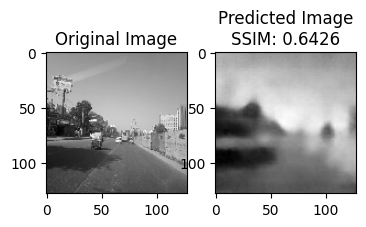

No module named 'pyopencl'


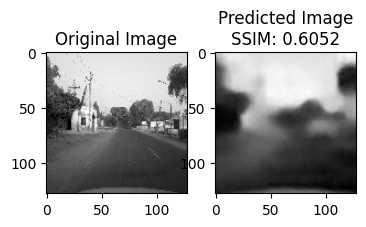

No module named 'pyopencl'


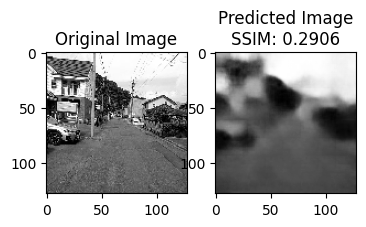

No module named 'pyopencl'


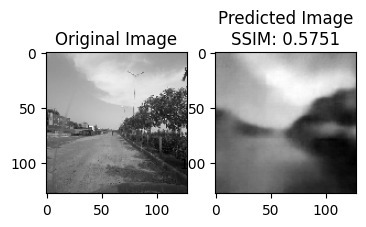

No module named 'pyopencl'


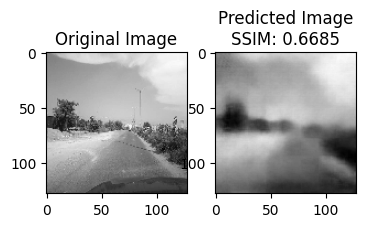

No module named 'pyopencl'


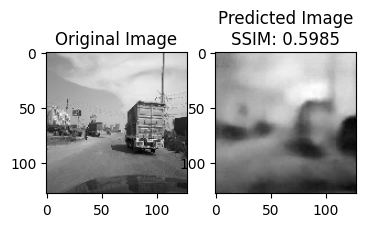

No module named 'pyopencl'


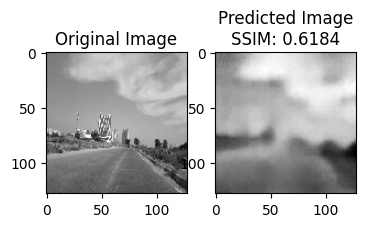

No module named 'pyopencl'


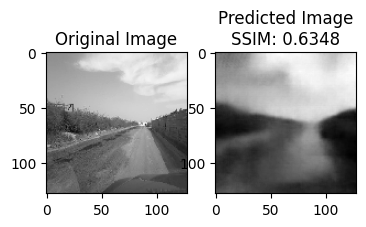

Average SSIM for damage images: 0.5792195327037543
Average Training Loss for damage images: 1.0242751612155043e-10


In [25]:
# Initialize variables to track cumulative SSIM and loss for damage images
total_ssim_damage = 0
total_loss_damage = 0

# Predict on the damage test set
test_predictions_damage = model.predict(X_test_damage[:100])

# Process each image in the damage dataset
for i in range(len(X_test_damage[:8])):
    original_img_damage = X_test_damage[i]
    predicted_img_damage = test_predictions_damage[i]

    # Calculate SSIM for damage images
    ssim_value_damage = calculate_ssim(original_img_damage, predicted_img_damage)
    total_ssim_damage += ssim_value_damage

    # Calculate and add the loss for damage images
    loss_values_damage = model.evaluate(original_img_damage.reshape(1, 128, 128, 1), predicted_img_damage.reshape(1, 128, 128, 1), verbose=0)
    total_loss_damage += loss_values_damage[0]

    # Plot the images
    plot_images(original_img_damage, predicted_img_damage, ssim_value_damage)

# Calculate average SSIM and loss for damage images
avg_ssim_damage = total_ssim_damage / len(X_test_damage[:8])
average_loss_damage = total_loss_damage / len(X_test_damage[:8])

# Print the results for damage images
print("Average SSIM for damage images:", avg_ssim_damage)
print("Average Training Loss for damage images:", average_loss_damage)

## Classification